![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [86]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

In [115]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [116]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

In [117]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [118]:
bikes.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,11.541613
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,6.915838
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,6.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,12.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,18.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,23.000000


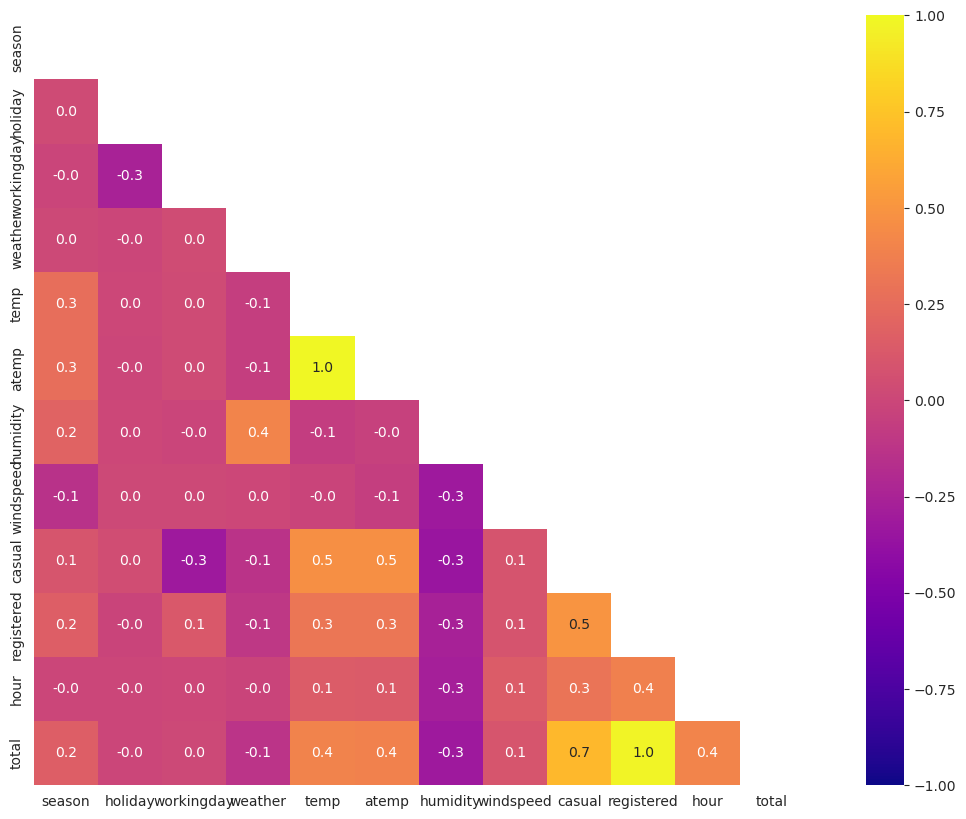

In [119]:
# Organizando columnas para la presentación de la matriz
tmp = bikes.copy()
total = bikes.total
del tmp['total']
tmp['total'] = total

# plotting
corr = tmp.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 10))
    ax = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, square=True, cmap='plasma', annot=True, fmt='.1f')

#### Season
Para la variable Season, se observa que en promedio 234 usuarios rentaron bicicletas para la temporada de verano, y donde menos rentaron (116 usuarios) corresponde la temporada de invierno.
Las temporadas de primavera y otoño presentaron valores similares de usuarios rentando bicicletas (215 y 198 respectivamente). Se puede inferir que en invierno dadas las condiciones climáticas las personas no tienden a rentar bicicletas.

#### Hour
Para la variable hour, se observa que en promedio las horas donde más usuarios rentan bicicletas son las 8:00 y las 17:00,18:00 y 19:00. Podemos relacionar estas horas con ingreso-salida de actividades laborales y recreación a tempranas horas de la noche.
Las horas donde menos se rentan bicicletas corresponden a altas horas de la madrugada (entre las 0:00 y 5:00) entendiendo que hay menor flujo de usuarios entre esas horas. Según la mediana, el 50% de usuarios rentan bicicletas a las 12:00, lo que da a entender que el alquiler se realiza de manera equitativa entre las dos mitades del día.



### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

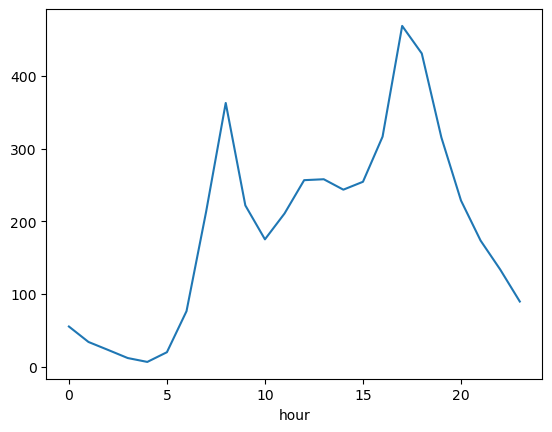

In [120]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

Esta gráfica nos muestra el promedio de usuarios que alquilan bicicletas a lo largo de las horas del día, obteniendo el pico máximo a las 17:00 y el mínimo a las 4:00

<AxesSubplot:xlabel='hour'>

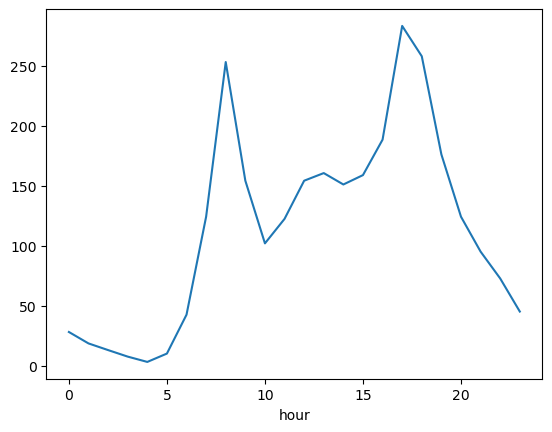

In [121]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
bikes[bikes['season'] == 1].groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour'>

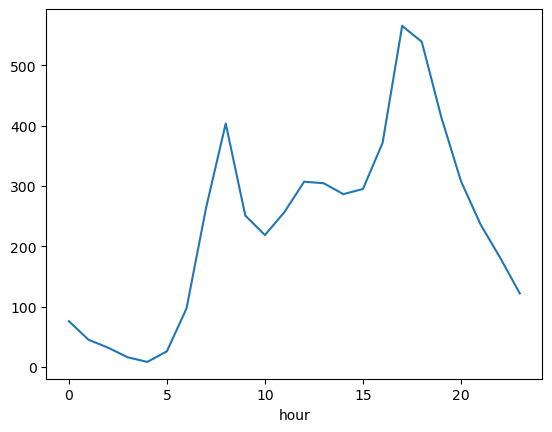

In [122]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes[bikes['season'] == 3].groupby('hour').total.mean().plot()


Las gráficas anteriores nos brindan información sobre el promedio de usuarios que alquilan bicicletas en las estaciones de invierno y verano. Podemos observar que ambas gráficas son muy parecidas en cuanto a su tendencia, sin embargo, la cantidad de usuarios es menor para la estación de invierno. También podemos observar que la gráfica de verano presenta valores mayores en el eje Y respecto a la primera gráfica (incluyendo todas las estaciones). Esto nos lleva a concluir que en invierno es cuando menos usuarios alquilan bicletas, y por el contrario, en verano es donde más alquiler se presenta.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [123]:
X = bikes[['hour']]
season_dummies = pd.get_dummies(bikes['season'], prefix='season',drop_first=True)
X = pd.concat([X, season_dummies], axis=1)
y = bikes['total']
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.33, random_state=0)

In [124]:
# Celda 3
# Crear el modelo de regresión lineal y ajustarlo con los datos de entrenamiento
regression_model = LinearRegression()
regression_model.fit(XTrain, yTrain)

# Predecir los valores de la variable dependiente utilizando los datos de prueba
yPred = regression_model.predict(XTest)

# Calcular los coeficientes de la regresión lineal
coeficientes = regression_model.coef_
intercepto = regression_model.intercept_

# Calcular el error cuadrático medio (MSE) utilizando los datos de prueba
mse = mean_squared_error(yTest, yPred)

# Imprimir los resultados
print("Coeficientes:", coeficientes)
print("Intercepto:", intercepto)
print("MSE:", mse)

Coeficientes: [ 10.62873885 100.90776793 119.01866421  87.2473903 ]
Intercepto: -9.563071266089423
MSE: 25644.421108938284


#### Interpretación de coeficientes
* **Const**: El intercepto de la regresión arrojó un valor de --9.56, esto no tiene sentido ya que no es posible tener un número total de usuarios negativo.
* **Hour**: Por cada incremento unitario en la hora de alquiler, la cantidad total de usuarios aumentará en 10,62.
* **Season_2**: De encontrarse en la estación primavera, el total de usuarios será mínimo de 100,9.
* **Season_3**: De encontrarse en la estación Verano, el total de usuarios será mínimo de 119,01.
* **Season_4**: De encontrarse en la estación Otoño, el total de usuarios será mínimo de 87,24.

Una de las limitaciones que presenta el modelo de regresión lineal, es que tenemos un rango horario de 0-24 hrs, que a pesar de ser númerico su interpretación es categórica. Esto puede sesgar el modelo y no presentar resultados adecuados, por lo que usar regresión lineal para este problema en particular podría ser limitante.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [125]:
# Definición de parámetros y criterios de parada
max_depth = 6
num_pct = 10
max_features = None
min_gain=0.001

#### Para la primera variable ('season') se calculan los posibles puntos de corte y el gini index de un punto especifico

In [191]:
X = bikes[['season','hour']]
y = bikes['total']
# Impresión variable a usar (season)
j = 0
print(X.columns[j])

season


In [192]:
# División de la variable season en num_ctp puntos (parámetro definido anteriormente) para obtener posibles puntos de corte
splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / num_pct).tolist())
splits = np.unique(splits)
splits

array([1., 2., 3., 4.])

In [193]:
# División de las observaciones usando el punto de corte en la posición 3 de la lista de splits
k=1
filter_l = X.iloc[:, j] < splits[k]

# División de la variable de respuesta de acuerdo a si la observación cumple o no con la regla binaria
# y_l: la observación tiene un valor menor al punto de corte seleccionado
# y_r: la observación tiene un valor mayor o igual al punto de corte seleccionado
y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [21]:
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del MSE para cada valor de máxima profundidad (max_depth)
MSE = []
for depth in max_depth_range:
    # Crear el modelo de árbol de regresión
    clfTree = DecisionTreeRegressor(max_depth=depth, random_state=1)
    # Aplicar validación cruzada con 5 folds y calcular el promedio de los scores
    scores = cross_val_score(clfTree, XTrain, yTrain, cv=5, scoring='neg_mean_squared_error')
    mse_scores = -scores.mean()
    
    # Ajustar el modelo con los datos de entrenamiento completos
    clfTree.fit(XTrain, yTrain)

    # Predecir los valores de la variable dependiente utilizando el árbol de regresión y los datos de prueba
    yPred = clfTree.predict(XTest)

    # Calcular el error cuadrático medio (MSE) utilizando los datos de prueba
    MSE.append(mean_squared_error(yTest, yPred))
print("El max_depth óptimo para el árbol es de ",MSE.index(min(MSE))+1,"y produce un MSE de:",min(MSE))

El max_depth óptimo para el árbol es de  8 y produce un MSE de: 13370.643254121012


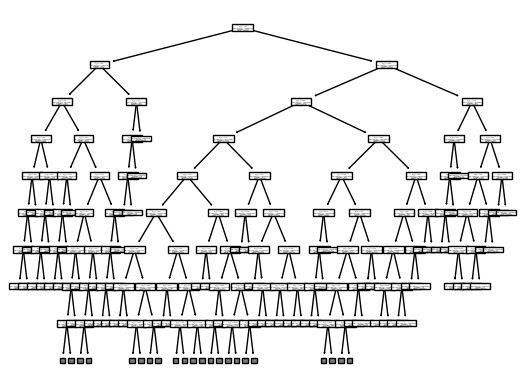

In [22]:
plot_tree(clfTree,max_depth=8)
plt.show()

Basandonos en la métrica MSE, concluimos que para este caso en particular un árbol de regresión produce menos error que una regresión lineal. El MSE del mejor árbol (13370) es mucho menor que el de la regresión lineal (25664), esto puede deberse a que el árbol realiza particiones en el espacio y no intenta modelar linealmente las variables, ajustandose mejor al problema planteado en este caso.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [23]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [24]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [25]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

#### Árbol de decisión

Text(0, 0.5, 'Accuracy')

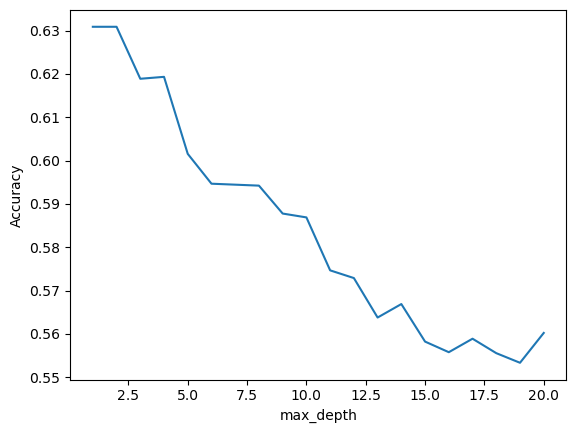

In [26]:
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())
    
    
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [27]:
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.6308888888888888, 2)

In [28]:
# max_depth=2 fue el mejor, se ajusta un árbol usando este valor 
clf = DecisionTreeClassifier(max_depth=2, random_state=1)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=1)

In [29]:
prediccionTree=clf.predict(X_test)
# Calcular el F1 score
f1 = f1_score(y_test, prediccionTree)

# Imprimir el resultado
print("F1 score:", f1)

F1 score: 0.6448598130841121


#### Regresión logística

In [30]:
# Crear un modelo de regresión logística y ajustarlo a los datos de entrenamiento
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)

# Predecir las etiquetas de la prueba
y_pred = clf.predict(X_test)

# Calcular la precisión y el F1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir los resultados
print("Accuracy:", accuracy)
print("F1 score:", f1)

Accuracy: 0.6126666666666667
F1 score: 0.6092804303967719


Para este caso, el árbol de decisión es ligeramente mejor que la regresión logística.

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth tome un valor de su elección\
-100 árboles de decisión donde min_samples_leaf tome un valor de su elección\
-100 regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

#### Árboles de decisión donde max_depth tome un valor de su elección

Se selecciona un valor de max_depth arbitrario de 8.

In [77]:
estimator=DecisionTreeClassifier(max_depth=8)
clf_a1 = BaggingClassifier(base_estimator=estimator, n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

In [78]:
clf_a1.fit(X_train, y_train)
y_pred_a1 = clf_a1.predict(X_test)
metrics.f1_score(y_pred_a1, y_test), metrics.accuracy_score(y_pred_a1, y_test)

(0.6582781456953642, 0.656)

#### Árboles de decisión donde min_samples_leaf tome un valor de su elección
Se selecciona un valor de min_samples_leaf arbitrario de 5.

In [81]:
from sklearn.ensemble import BaggingClassifier
estimator=DecisionTreeClassifier(min_samples_leaf=5)
clf_a2 = BaggingClassifier(base_estimator=estimator, n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

In [82]:
clf_a2.fit(X_train, y_train)
y_pred_a2 = clf_a2.predict(X_test)
metrics.f1_score(y_pred_a2, y_test), metrics.accuracy_score(y_pred_a2, y_test)

(0.6582947785855915, 0.6553333333333333)

#### 100 regresiones logísticas

In [84]:
estimator=LogisticRegression()
clf_lr = BaggingClassifier(base_estimator=estimator, n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

In [85]:
# Predicción y desempeño al hacer votación mayoritaria
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)
metrics.f1_score(y_pred_lr, y_test), metrics.accuracy_score(y_pred_lr, y_test)

(0.6136210384356034, 0.618)

#### Ensamble de los 3 modelos

In [90]:
# Creamos un modelo de votación que combine los 3 modelos de decisión
voting_clf = VotingClassifier(estimators=[('clf_a1', clf_a1), ('clf_a2', clf_a2),('clf_lr',clf_lr)], voting='hard')

# Entrenamos el modelo de votación en los datos de entrenamiento
voting_clf.fit(X_train, y_train)
# Realizamos predicciones
y_pred_voting_clf=voting_clf.predict(X_test)
# Calculamos métricas
metrics.f1_score(y_pred_voting_clf, y_test), metrics.accuracy_score(y_pred_voting_clf, y_test)

(0.6604774535809018, 0.6586666666666666)

Podemos observar que los mejores modelos son ambos árboles de decisión, con un accuracy y f1 score similar (0.65 y 0.65). La regresión logística es el mejor que produce un desempeño más bajo. El ensamble de los 3 algoritmos mediante votación mayoritaria mejora un poco las métricas (0.61 y 0.61) , por lo que demuestra que el ensamble de los modelos es la solución más eficiente.

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

#### Árboles de decisión donde max_depth tome un valor de su elección

Se selecciona un valor de max_depth arbitrario de 8.

In [103]:
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf_a1.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf_a1.n_estimators))

for i in range(clf_a1.n_estimators):
    oob_sample = ~clf_a1.estimators_samples_[i]
    y_pred_ = clf_a1.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf_a1.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

In [104]:
# Desempeño al hacer votación ponderada
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.656084656084656, 0.6533333333333333)

#### Árboles de decisión donde min_samples_leaf tome un valor de su elección
Se selecciona un valor de min_samples_leaf arbitrario de 5.

In [109]:
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf_a2.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf_a2.n_estimators))

for i in range(clf_a2.n_estimators):
    oob_sample = ~clf_a2.estimators_samples_[i]
    y_pred_ = clf_a2.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf_a2.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

In [110]:
# Desempeño al hacer votación ponderada
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.6504394861392833, 0.6553333333333333)

#### 100 regresiones logísticas

In [111]:
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf_lr.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf_lr.n_estimators))

for i in range(clf_lr.n_estimators):
    oob_sample = ~clf_lr.estimators_samples_[i]
    y_pred_ = clf_lr.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf_lr.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

In [112]:
# Desempeño al hacer votación ponderada
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.6160053799596503, 0.6193333333333333)

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

Según los resultados obtenidos, para este caso en particular no se evidencian diferencias significativas en ambos métodos de votación pues los F1 Score y Accuracy resultaron similares para cada uno de los modelos planteados (2 árboles de decisión y una regresión logística). Esto es un indicio de que los modelos utilizados presentan un desempeño similar, ya que al no haber mucha diferencia en los dos métodos da a suponer que los pesos de la votación ponderada son similares (como sucede en la votación mayoritaria que son iguales). A continuación, observemos la distribución de la variable de interés.

In [198]:
df["Popular"].value_counts()

1    3000
0    3000
Name: Popular, dtype: int64

Al presentarse un balanceo entre las clases, facilita el desarrollo de los modelos a utilizar. Aunque el desempeño de la regresión logística es ligeramente menor a los árboles de decisión, no se aprecian diferencias significativas en las predicciones para decantarse por uno de los dos métodos de votación. Adicionalmente, se notó una ligera mejoría al utilizar métodos de ensamblaje, lo cual confirma la teoría.


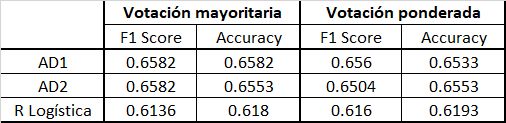